Student Score Classification With Neural Network

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [42]:
# 1. Veri Yükleme
data = pd.read_csv('/content/Student performance in mathematics.csv')

In [43]:
# 2. Hedef Değişken Oluşturma
data['average_score'] = (data['Math score'] + data['Reading score'] + data['Writing score']) / 3

def assign_label(avg):
    if avg < 60:
        return 0  # Başarısız
    elif avg < 80:
        return 1  # Orta
    else:
        return 2  # Başarılı

data['label'] = data['average_score'].apply(assign_label)


In [44]:
# 3. Özellik ve hedef ayrımı
X = data[['Gender', 'Race/ethnicity', 'Parental level of education', 'Lunch', 'Test preparation course',
          'Math score', 'Reading score', 'Writing score']]
y = data['label']

In [45]:
# 4. Preprocessing
categorical_cols = ['Gender', 'Race/ethnicity', 'Parental level of education', 'Lunch', 'Test preparation course']
numeric_cols = ['Math score', 'Reading score', 'Writing score']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

X_processed = preprocessor.fit_transform(X)

In [46]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
# 6. SMOTE ile Sınıf Dengesi
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [48]:
# 7. One-hot Encoding for y
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [49]:
# 8. Model Kurulumu
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# 9. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [51]:
# 10. Eğitim
history = model.fit(
    X_train, y_train_categorical,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1875 - loss: 1.8476
Epoch 1: val_accuracy improved from -inf to 0.54762, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3791 - loss: 1.2961 - val_accuracy: 0.5476 - val_loss: 0.9794 - learning_rate: 0.0010
Epoch 2/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.6014
Epoch 2: val_accuracy improved from 0.54762 to 0.71429, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7214 - loss: 0.5696 - val_accuracy: 0.7143 - val_loss: 0.8702 - learning_rate: 0.0010
Epoch 3/300
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8338 - loss: 0.4237  
Epoch 3: val_accuracy improved from 0.71429 to 0.83333, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8360 - loss: 0.4233 - val_accuracy: 0.8333 - val_loss: 0.7730 - learning_rate: 0.0010
Epoch 4/300
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.91      1.00      0.95        20
           2       1.00      1.00      1.00        11

    accuracy                           0.95        42
   macro avg       0.97      0.94      0.95        42
weighted avg       0.96      0.95      0.95        42



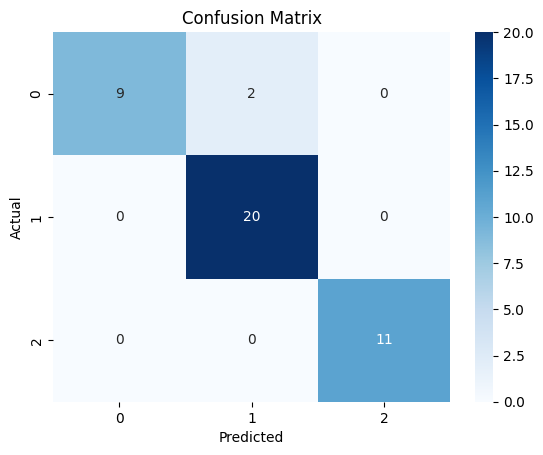

In [39]:
# 11. Değerlendirme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

conf_mat = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Başarısız', 'Orta', 'Başarılı'],
            yticklabels=['Başarısız', 'Orta', 'Başarılı'])

NameError: name 'conf_mat' is not defined

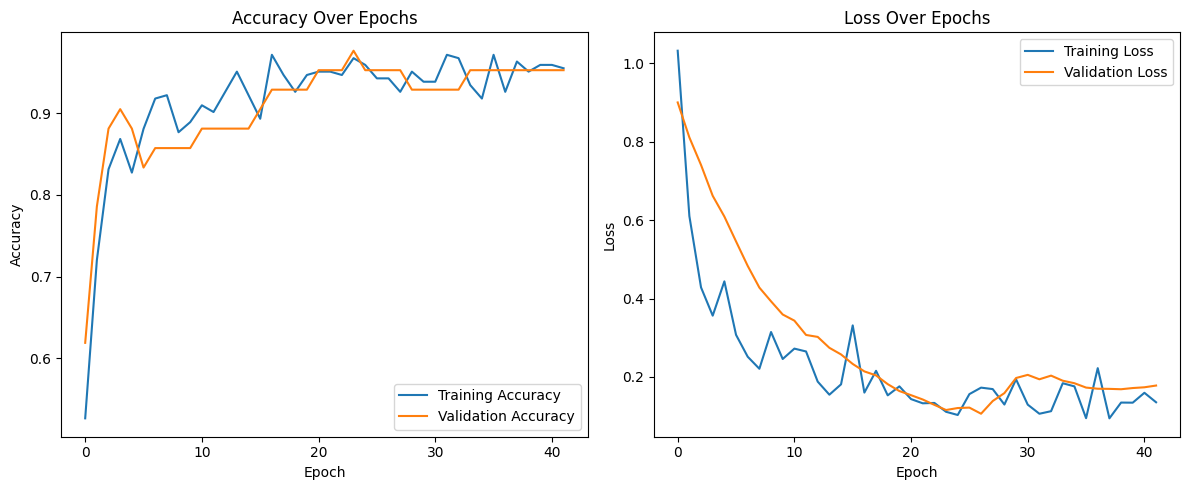

In [40]:
# 12. Eğitim/Kayıp Eğrileri
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Lazy Prediction

In [53]:
!pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00


In [54]:
# LazyPredict için gerekli import
from lazypredict.Supervised import LazyClassifier

In [55]:
# LazyPredict ile Klasik Modellerin Performansını Ölçelim
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [56]:
# LazyPredict Eğitimi
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [63]:
# Modellerin Performansları
print("\nLazyPredict Modellerinin Performansı:\n")
models


LazyPredict Modellerinin Performansı:



,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,None,1.00,0.28
BaggingClassifier,1.00,1.00,None,1.00,0.07
DecisionTreeClassifier,1.00,1.00,None,1.00,0.02
XGBClassifier,1.00,1.00,None,1.00,0.47
LGBMClassifier,1.00,1.00,None,1.00,0.18
RandomForestClassifier,0.98,0.97,None,0.98,0.54
LogisticRegression,0.98,0.97,None,0.98,0.05
PassiveAggressiveClassifier,0.95,0.97,None,0.95,0.05
ExtraTreesClassifier,0.95,0.95,None,0.95,0.24


In [ ]:
# 13. SHAP Analizi
# Özellik isimlerini al (OneHotEncoder sonrası)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_features) + numeric_cols

# SHAP için veri setinin bir alt kümesini kullan (hesaplama süresini azaltmak için)
X_test_sample = X_test[:100]  # İlk 100 örnek

# SHAP KernelExplainer ile modelin tahminlerini açıkla
explainer = shap.KernelExplainer(model.predict, X_train[:100])  # Eğitim setinden 100 örnek
shap_values = explainer.shap_values(X_test_sample)

# SHAP özet grafiği (tüm sınıflar için)
for class_idx in range(3):  # Her sınıf için (Başarısız, Orta, Başarılı)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[class_idx], X_test_sample, feature_names=feature_names,
                     show=False, plot_type="bar")
    plt.title(f"SHAP Feature Importance for Class {class_idx} ({['Başarısız', 'Orta', 'Başarılı'][class_idx]})")
    plt.tight_layout()
    plt.show()

# SHAP özet grafiği (nokta grafiği, tüm sınıflar için)
for class_idx in range(3):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[class_idx], X_test_sample, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for Class {class_idx} ({['Başarısız', 'Orta', 'Başarılı'][class_idx]})")
    plt.tight_layout()
    plt.show()